In [2]:
print("OM GANN GANPATAYE NAMAH")

OM GANN GANPATAYE NAMAH


#### Step 1: Temporal Feature Engineering (Rolling Statistics)

We generate time-series features to capture the "velocity" and "instability" of engine degradation.

* **Strategy:** Apply a **Rolling Window of 10 cycles** for all datasets.
* **Rolling Mean:** Captures the smoothed degradation trend, filtering out sensor noise.
* **Rolling Std:** Captures the volatility (jitter) of the sensor, which typically increases near failure.
* **Grouping:** All calculations are grouped by `unit_id` to prevent data leakage between engines.
* **Handling NaNs:** Initial window gaps (first 9 cycles) are backfilled to preserve data shape.

In [2]:
import pandas as pd
import numpy as np
import os

# Setup paths
INPUT_DIR = "data/normalised-clean-data"
OUTPUT_DIR = "data/engineered_features"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [8]:
WINDOW_SIZE = 10

def create_rolling_features(df, window=10):
    """
    Calculates rolling mean and std for sensor columns, grouped by unit_id.
    """
    # Identify sensor columns (normalized or raw)
    sensor_cols = [c for c in df.columns if c.startswith('sensor_')]
    
    # Sort by engine and time to ensure correct rolling direction
    df = df.sort_values(['unit_id', 'time'])
    
    # 1. Rolling Mean (Trend)
    df[[f'{c}_mean' for c in sensor_cols]] = df.groupby('unit_id')[sensor_cols].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    
    # 2. Rolling Std (Volatility)
    df[[f'{c}_std' for c in sensor_cols]] = df.groupby('unit_id')[sensor_cols].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    )
    
    # Handle NaNs: Backfill (to keep first 9 times) then fill remaining with 0
    df = df.groupby('unit_id').apply(lambda x: x.bfill()).reset_index(drop=True)
    df = df.fillna(0)
    
    return df

In [9]:
# --- Execution Loop ---
datasets = ['FD001', 'FD002', 'FD003', 'FD004']

for ds in datasets:
    for mode in ['train', 'test']:
        file_name = f"{mode}_{ds}_normalized.csv"
        file_path = os.path.join(INPUT_DIR, file_name)
        
        if os.path.exists(file_path):
            print(f"Processing {file_name}...")
            
            # Load & Engineer
            df = pd.read_csv(file_path)
            df_engineered = create_rolling_features(df, window=WINDOW_SIZE)
            
            # Save
            save_name = f"{mode}_{ds}_engineered.csv"
            df_engineered.to_csv(os.path.join(OUTPUT_DIR, save_name), index=False)
            print(f"   -> Saved: {save_name} ({df_engineered.shape[1]} cols)")
        else:
            print(f"   -> File not found: {file_name}")

Processing train_FD001_normalized.csv...
   -> Saved: train_FD001_engineered.csv (50 cols)
Processing test_FD001_normalized.csv...
   -> Saved: test_FD001_engineered.csv (48 cols)
Processing train_FD002_normalized.csv...
   -> Saved: train_FD002_engineered.csv (53 cols)
Processing test_FD002_normalized.csv...
   -> Saved: test_FD002_engineered.csv (51 cols)
Processing train_FD003_normalized.csv...
   -> Saved: train_FD003_engineered.csv (50 cols)
Processing test_FD003_normalized.csv...
   -> Saved: test_FD003_engineered.csv (48 cols)
Processing train_FD004_normalized.csv...
   -> Saved: train_FD004_engineered.csv (41 cols)
Processing test_FD004_normalized.csv...
   -> Saved: test_FD004_engineered.csv (39 cols)


#### **Rolling Window Comparison Visualization**

We visualize the effect of different rolling window sizes ($W=10$ vs $W=15$) to ensure our feature engineering strategy is sound.

* **Objective:** Compare smoothing levels across Steady State (FD001/003) and Variable State (FD002/004) datasets.
* **10-Cycle Window:** Provides higher responsiveness to quick changes but may retain more sensor noise.
* **15-Cycle Window:** Provides deeper smoothing, which is helpful for "Variable" datasets to bridge the gap between regime transitions.
* **Visual Check:** We look for the "Knee" (the point where degradation accelerates) to ensure it remains sharp and detectable.

-- found that window 10 will work just fine for all datasets.

Saved: feature_plots/rolling_visuals\FD001_all_sensors_rolling.png


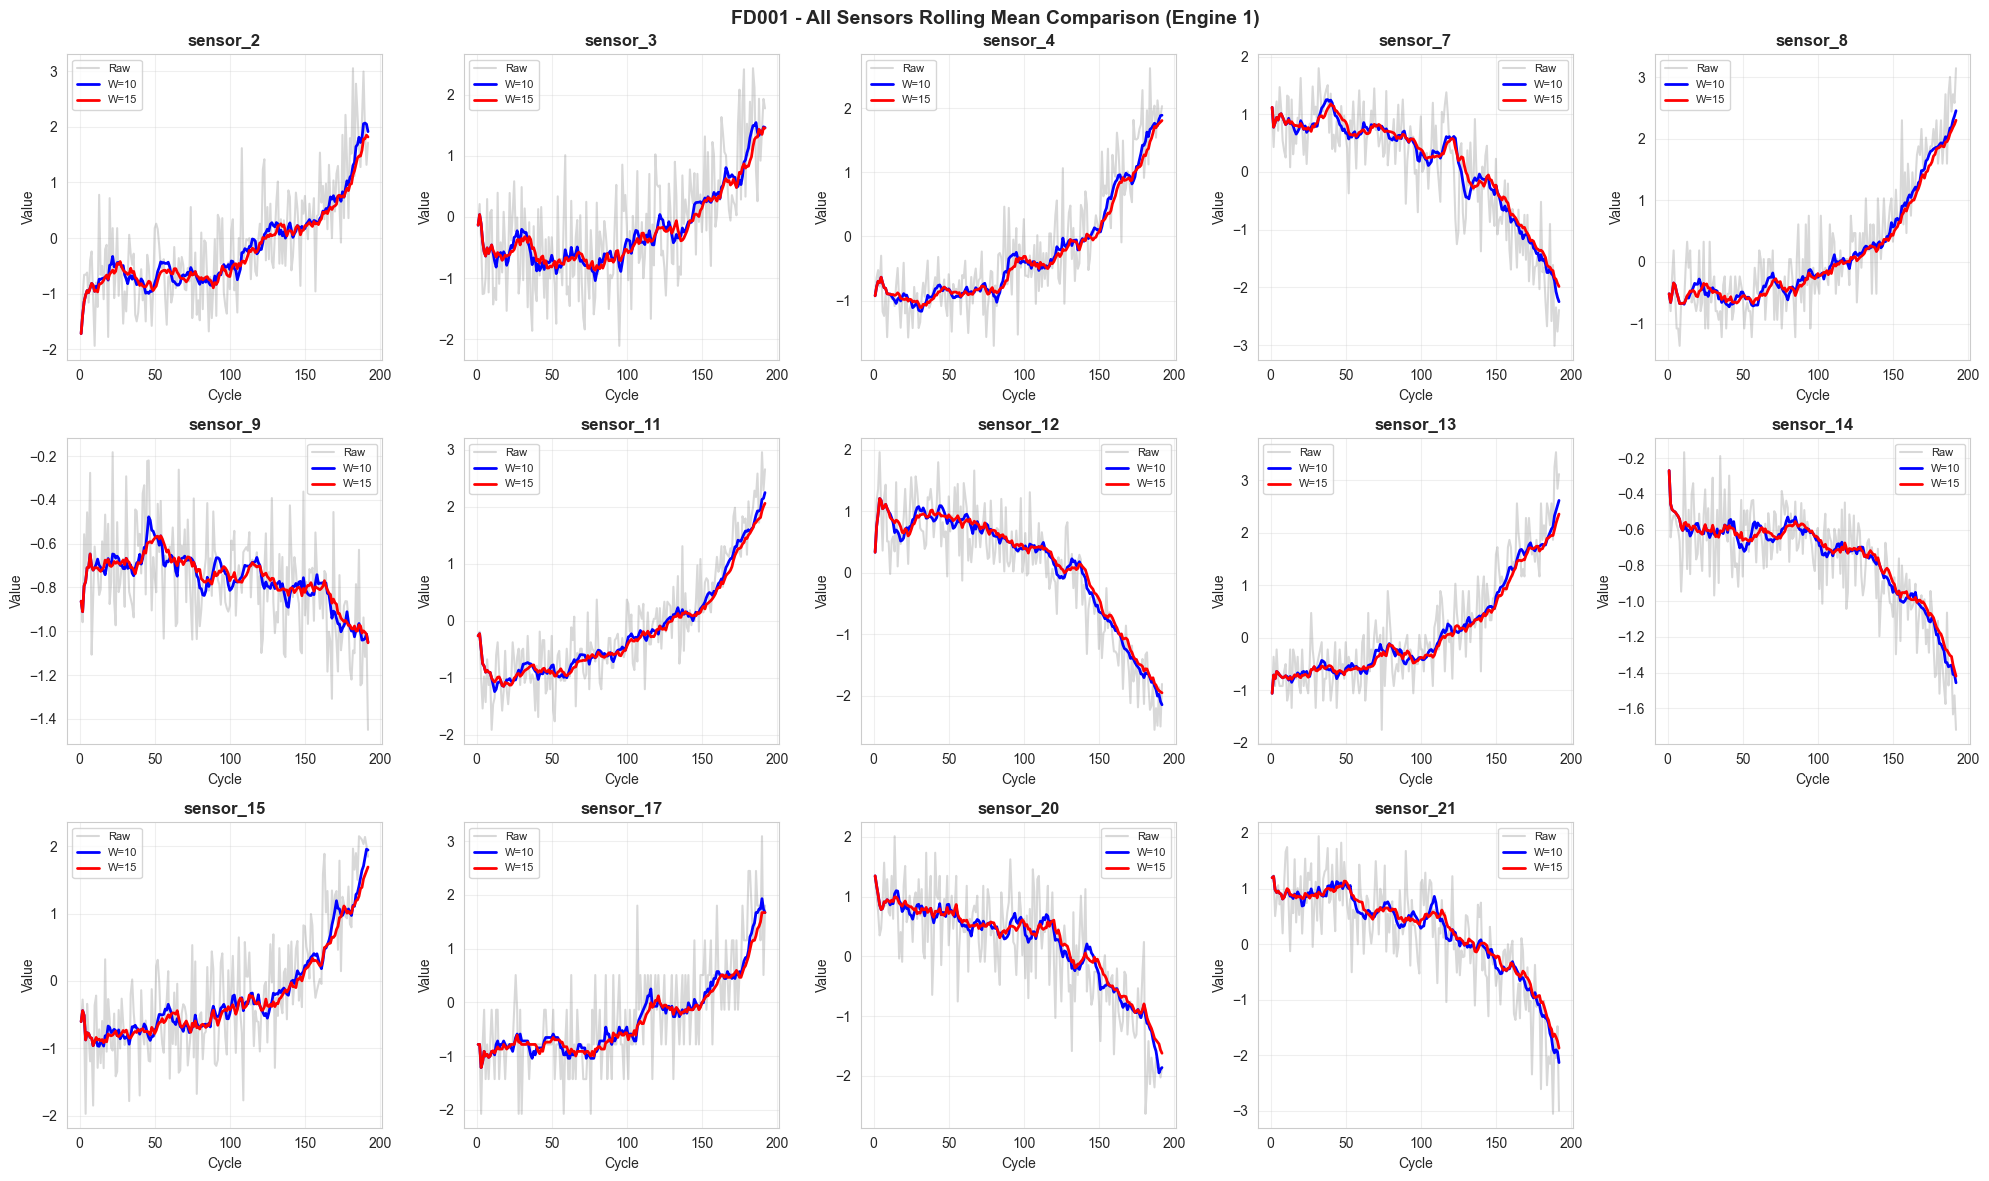

Saved: feature_plots/rolling_visuals\FD002_all_sensors_rolling.png


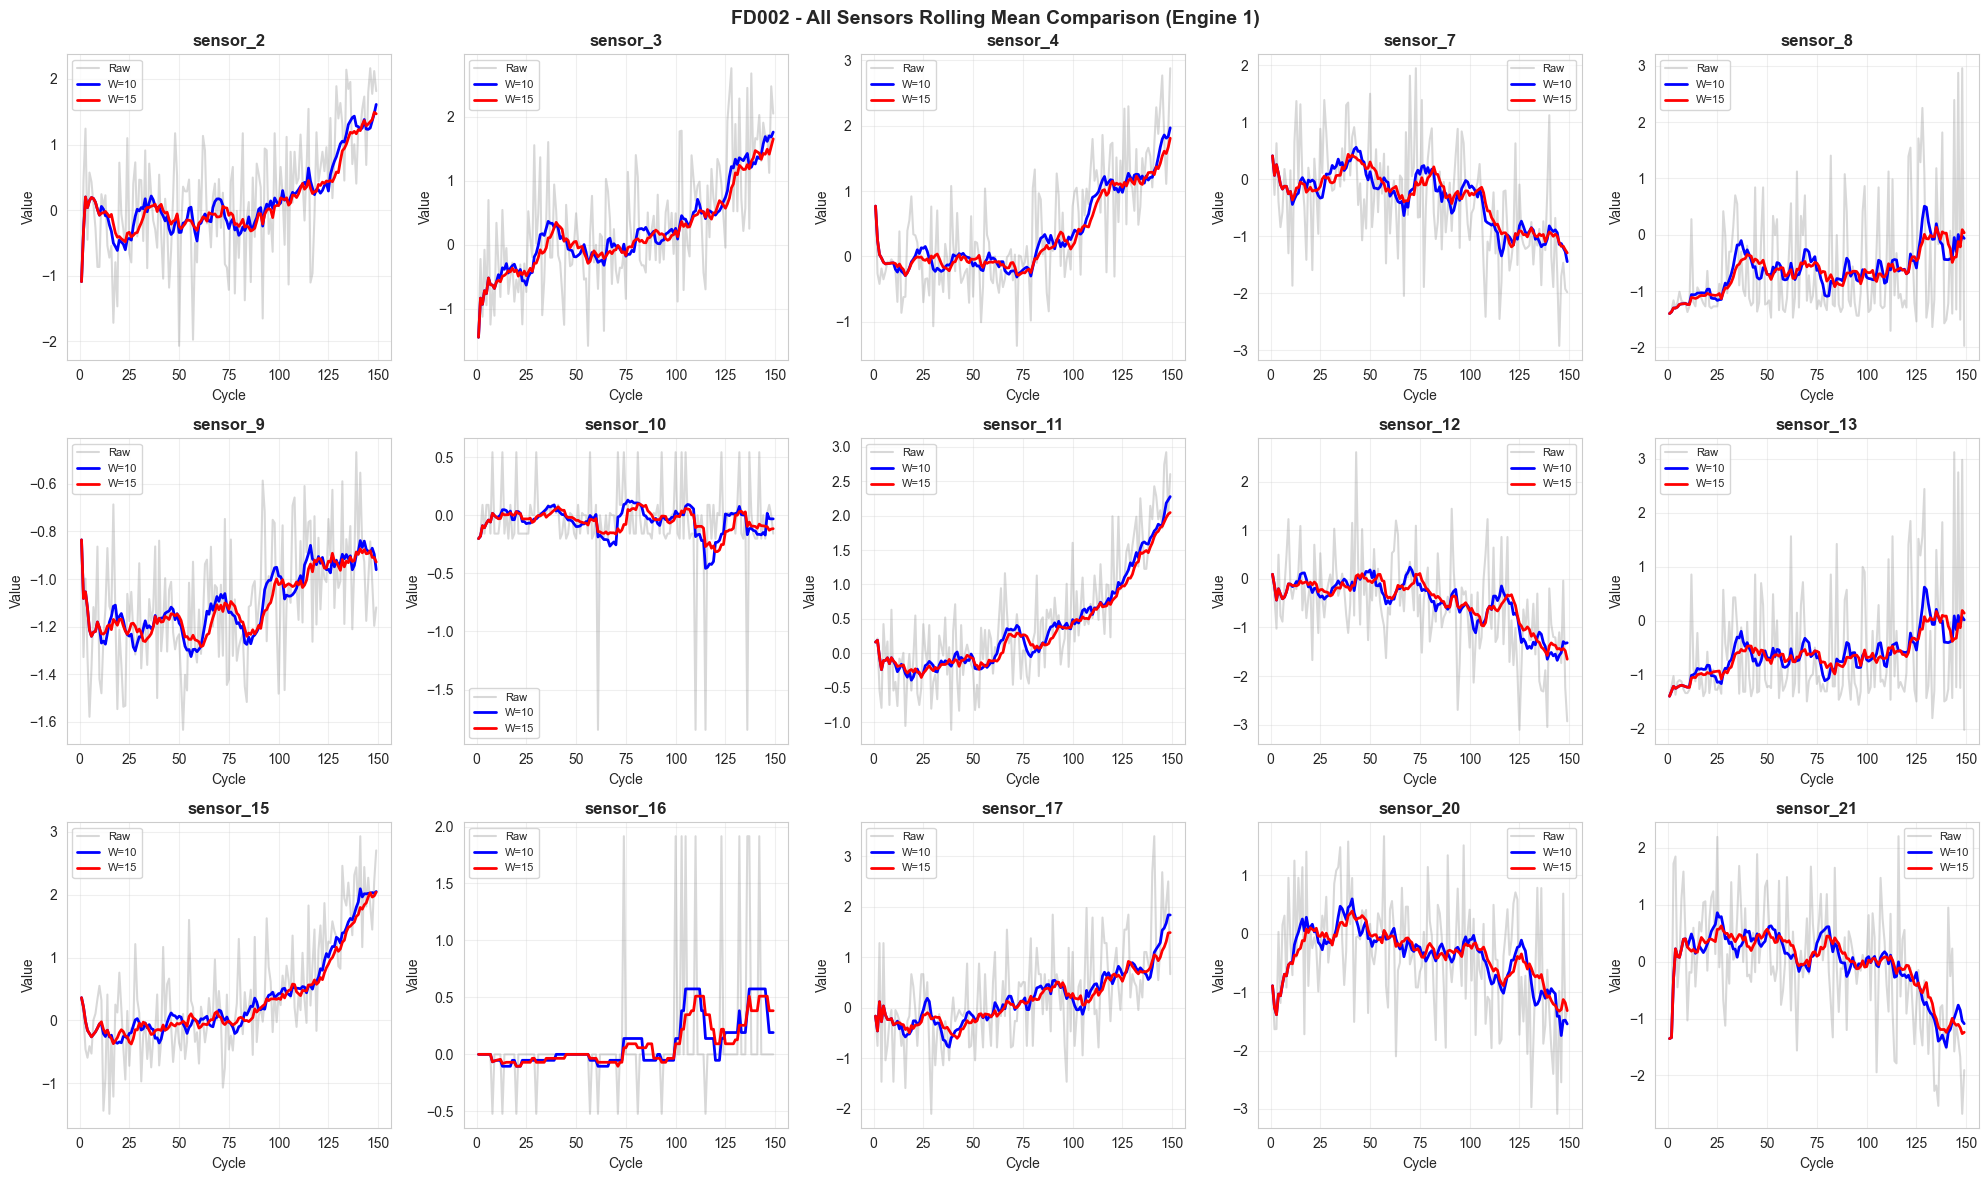

Saved: feature_plots/rolling_visuals\FD003_all_sensors_rolling.png


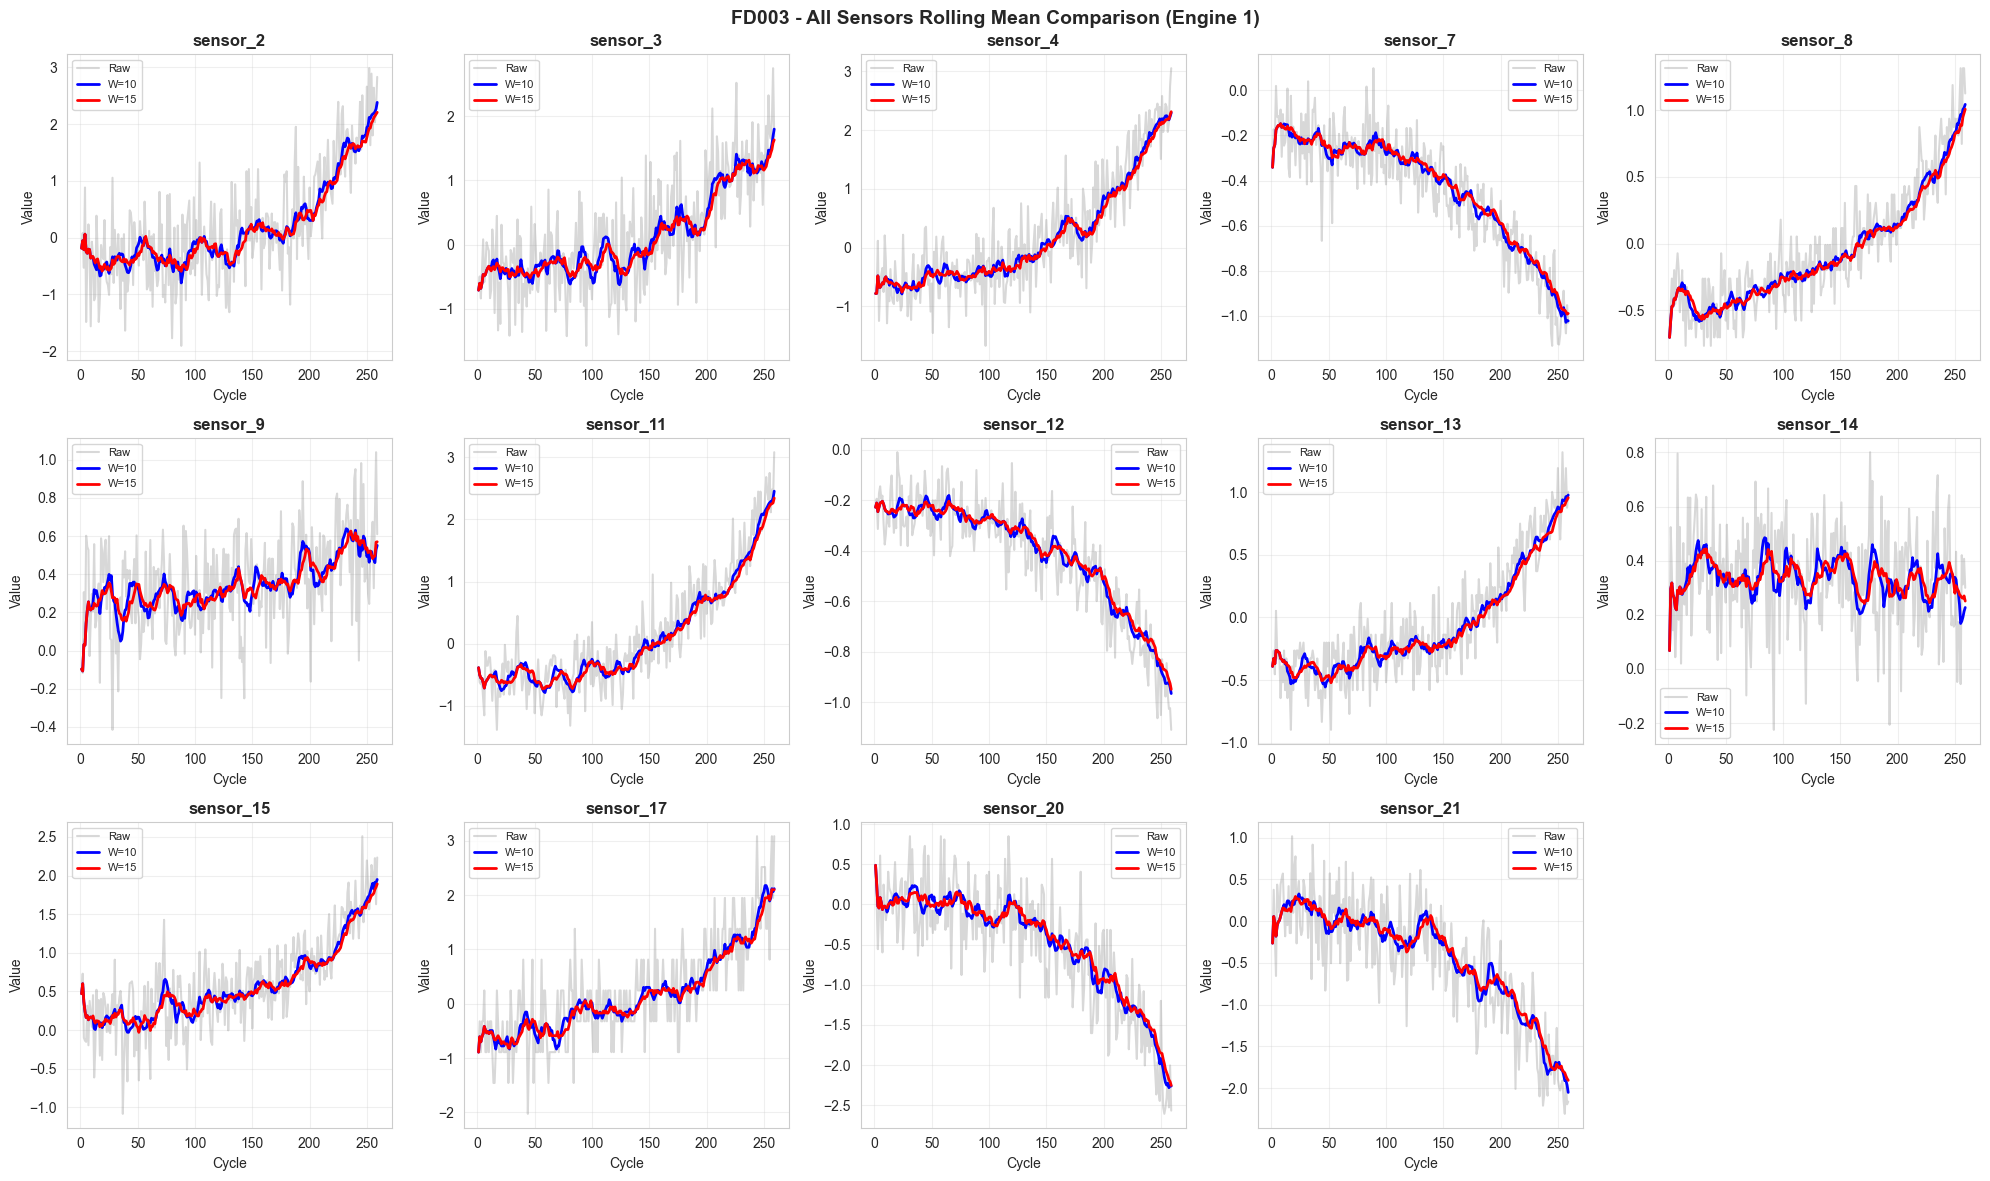

Saved: feature_plots/rolling_visuals\FD004_all_sensors_rolling.png


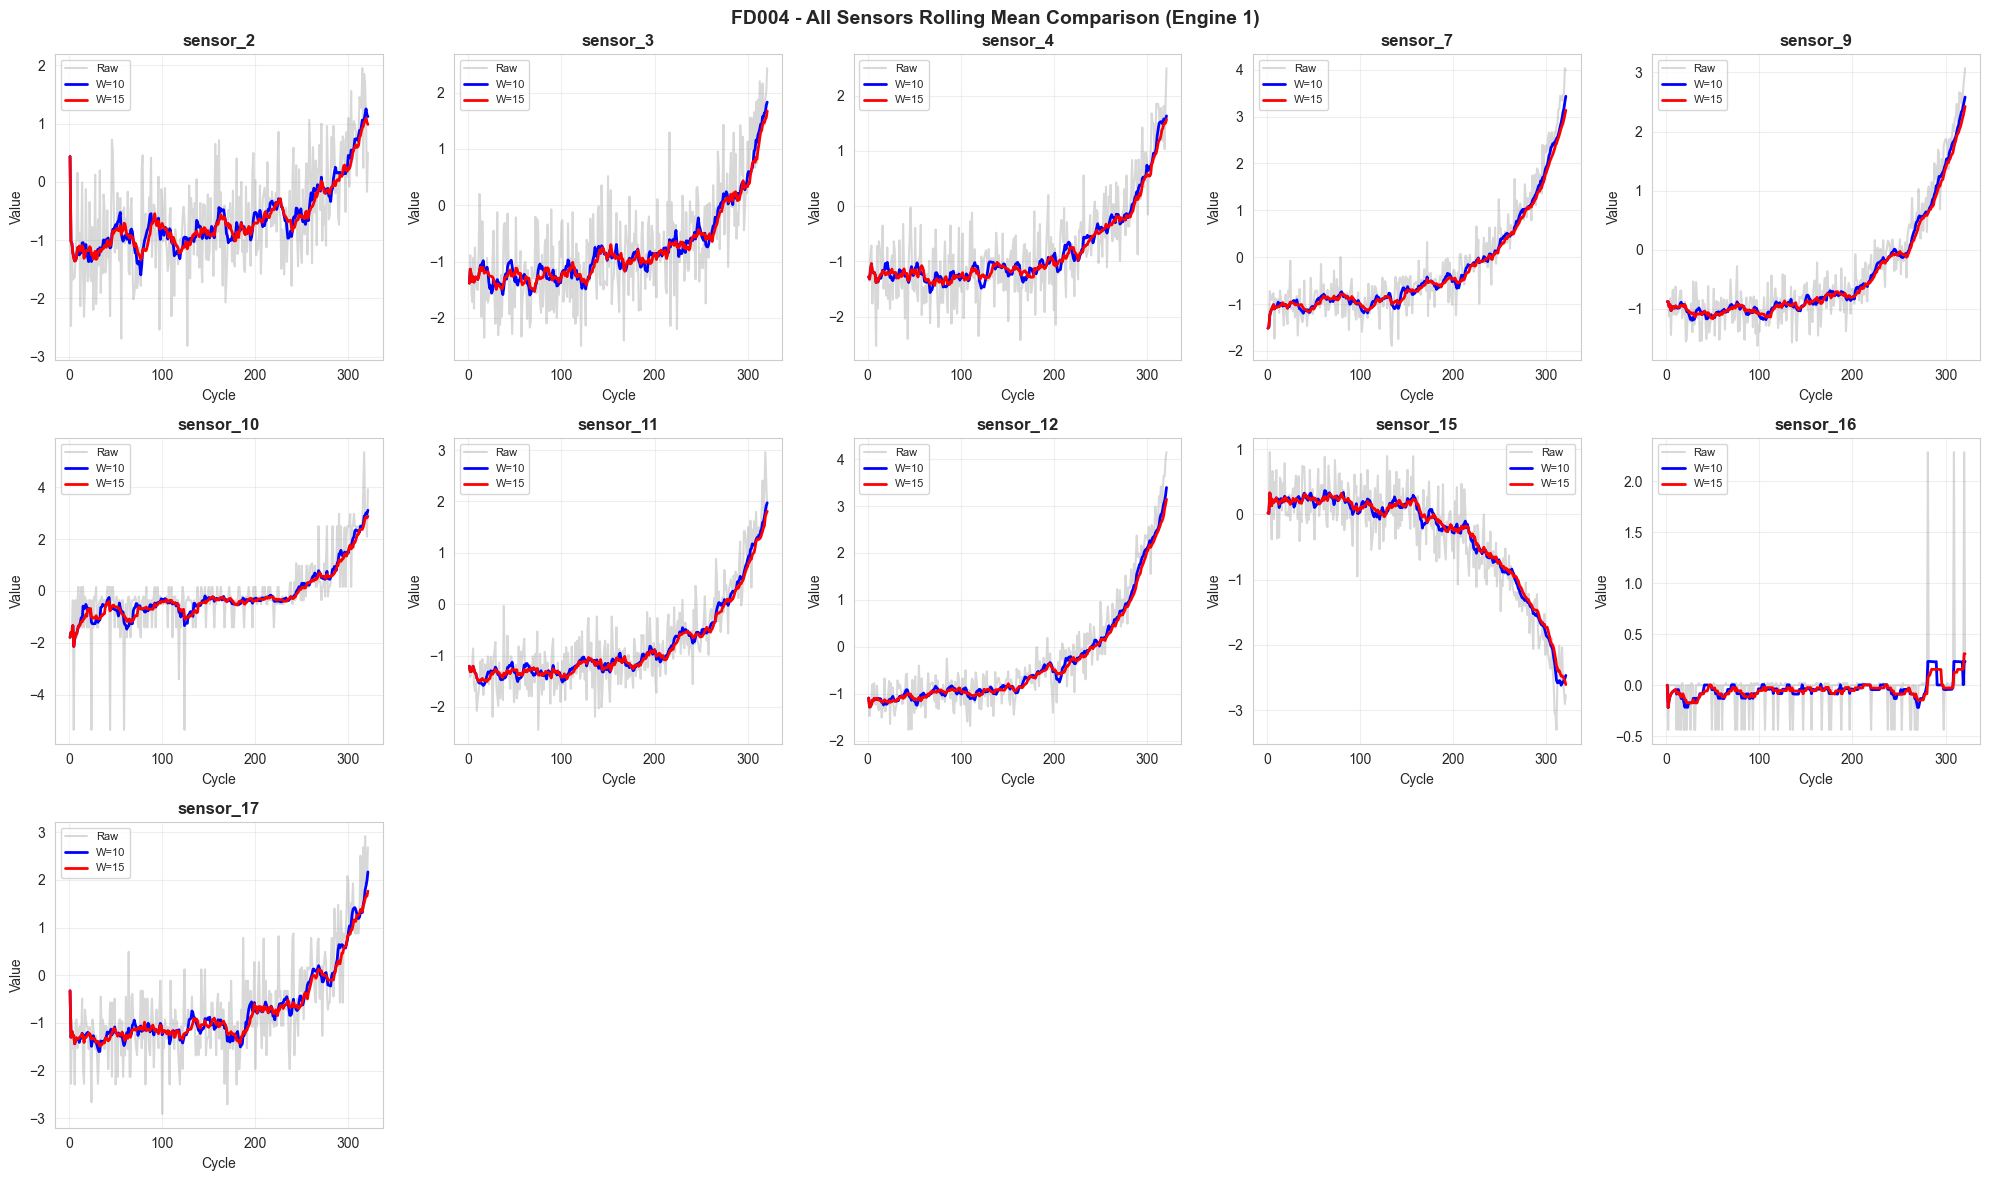

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def visualize_all_sensors_rolling(dataset_list, input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    sns.set_style("whitegrid")
    
    for ds in dataset_list:
        path = os.path.join(input_dir, f"train_{ds}_normalized.csv")
        if not os.path.exists(path):
            continue
        
        df = pd.read_csv(path)
        unit_id = df['unit_id'].min()
        sample = df[df['unit_id'] == unit_id].sort_values('time')
        
        sensor_cols = [c for c in df.columns if c.startswith('sensor_')]
        num_sensors = len(sensor_cols)
        
        rows = (num_sensors + 4) // 5
        fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
        axes = axes.flatten()
        
        for idx, sensor in enumerate(sensor_cols):
            ax = axes[idx]
            
            w10 = sample[sensor].rolling(window=10, min_periods=1).mean()
            w15 = sample[sensor].rolling(window=15, min_periods=1).mean()
            
            ax.plot(sample['time'], sample[sensor], alpha=0.3, label='Raw', color='gray')
            ax.plot(sample['time'], w10, label='W=10', linewidth=2, color='blue')
            ax.plot(sample['time'], w15, label='W=15', linewidth=2, color='red')
            
            ax.set_title(f"{sensor}", fontweight='bold')
            ax.set_xlabel("Cycle")
            ax.set_ylabel("Value")
            ax.legend(fontsize=8)
            ax.grid(alpha=0.3)
        
        for idx in range(num_sensors, len(axes)):
            fig.delaxes(axes[idx])
        
        plt.suptitle(f"{ds} - All Sensors Rolling Mean Comparison (Engine {unit_id})", fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        save_path = os.path.join(output_dir, f"{ds}_all_sensors_rolling.png")
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
        print(f"Saved: {save_path}")
        plt.show()
        plt.close()

visualize_all_sensors_rolling(
    dataset_list=['FD001', 'FD002', 'FD003', 'FD004'],
    input_dir="data/normalised-clean-data",
    output_dir="feature_plots/rolling_visuals"
)

#### **Step 2: Lag/Delta Feature Extraction (Velocity)**

We introduce "Velocity" features to measure the rate of sensor change over time.

* **Strategy:** Calculate the **Delta** (difference) between the current cycle and 5 cycles prior.
* **Objective:** Help the model distinguish between a stable high reading and a rapidly accelerating degradation trend.
* **Calculation:** `sensor(t) - sensor(t-5)`, grouped by `unit_id`.
* **Handling NaNs:** The initial 5-cycle gap is backfilled per engine to maintain data continuity.

In [14]:
# --- Configuration ---
LAG_STEP = 5

def add_lag_features(df, lag=5):
    """
    Calculates the difference between current sensor values and values 'lag'times ago.
    """
    # Identify the base sensor columns
    sensor_cols = [c for c in df.columns if c.startswith('sensor_') and '_' not in c]
    
    # If columns were renamed, just look for the base sensor names
    if not sensor_cols:
        sensor_cols = [c for c in df.columns if c.startswith('sensor_') and 'mean' not in c and 'std' not in c]

    # Sort to ensure time-consistency
    df = df.sort_values(['unit_id', 'time'])
    
    # Calculate Lag Delta (Current - Previous)
    # We use .diff() within a group to find the change over N steps
    for col in sensor_cols:
        df[f'{col}_delta'] = df.groupby('unit_id')[col].diff(periods=lag)
    
    # Fill window initialization NaNs with backfill per engine
    df = df.groupby('unit_id', group_keys=False).apply(lambda x: x.bfill())
    
    # Fill any remaining (if engine is shorter than lag) with 0
    df = df.fillna(0)
    
    return df

In [15]:
# --- Execution ---
# Note: We load from the 'engineered_features' folder where Step 1 was saved
for ds in ['FD001', 'FD002', 'FD003', 'FD004']:
    for mode in ['train', 'test']:
        file_name = f"{mode}_{ds}_engineered.csv"
        file_path = os.path.join(OUTPUT_DIR, file_name)
        
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df_with_lags = add_lag_features(df, lag=LAG_STEP)
            
            # Save back to same location or overwrite
            df_with_lags.to_csv(file_path, index=False)
            print(f"✅ Added Lag Features to {file_name}: {df_with_lags.shape[1]} total columns")

✅ Added Lag Features to train_FD001_engineered.csv: 64 total columns
✅ Added Lag Features to test_FD001_engineered.csv: 62 total columns
✅ Added Lag Features to train_FD002_engineered.csv: 68 total columns
✅ Added Lag Features to test_FD002_engineered.csv: 66 total columns
✅ Added Lag Features to train_FD003_engineered.csv: 64 total columns
✅ Added Lag Features to test_FD003_engineered.csv: 62 total columns
✅ Added Lag Features to train_FD004_engineered.csv: 52 total columns
✅ Added Lag Features to test_FD004_engineered.csv: 50 total columns


**Why Lag=5?**

The choice of a 5-cycle lag is designed to capture the **physical velocity** of engine wear:
* **Stability:** 5 cycles are enough to distinguish a real trend from random sensor noise.
* **Agility:** A short lag ensures the model reacts quickly to rapid degradation in the final stages of engine life.
* **Synergy:** This complements our 10-cycle rolling mean by providing a "mid-window" acceleration signal.

#### **Step 2.5: Visual Validation of Lag Features**

We visualize the newly created **Lag Features** (Delta) against the **Rolling Mean** to observe how they capture the rate of change.

* **Objective:** Compare the smoothed trend (Rolling Mean) with the acceleration signal (Delta Lag=5).
* **Delta Signal:** Represents the velocity of degradation; we expect to see these values deviate from zero as the engine approaches failure.
* **Validation:** We check if the Delta feature provides a "sharper" reaction to the end-of-life degradation than the rolling mean alone.

✅ Saved plot: feature_plots/final_feature_validation\FD001_feature_check.png


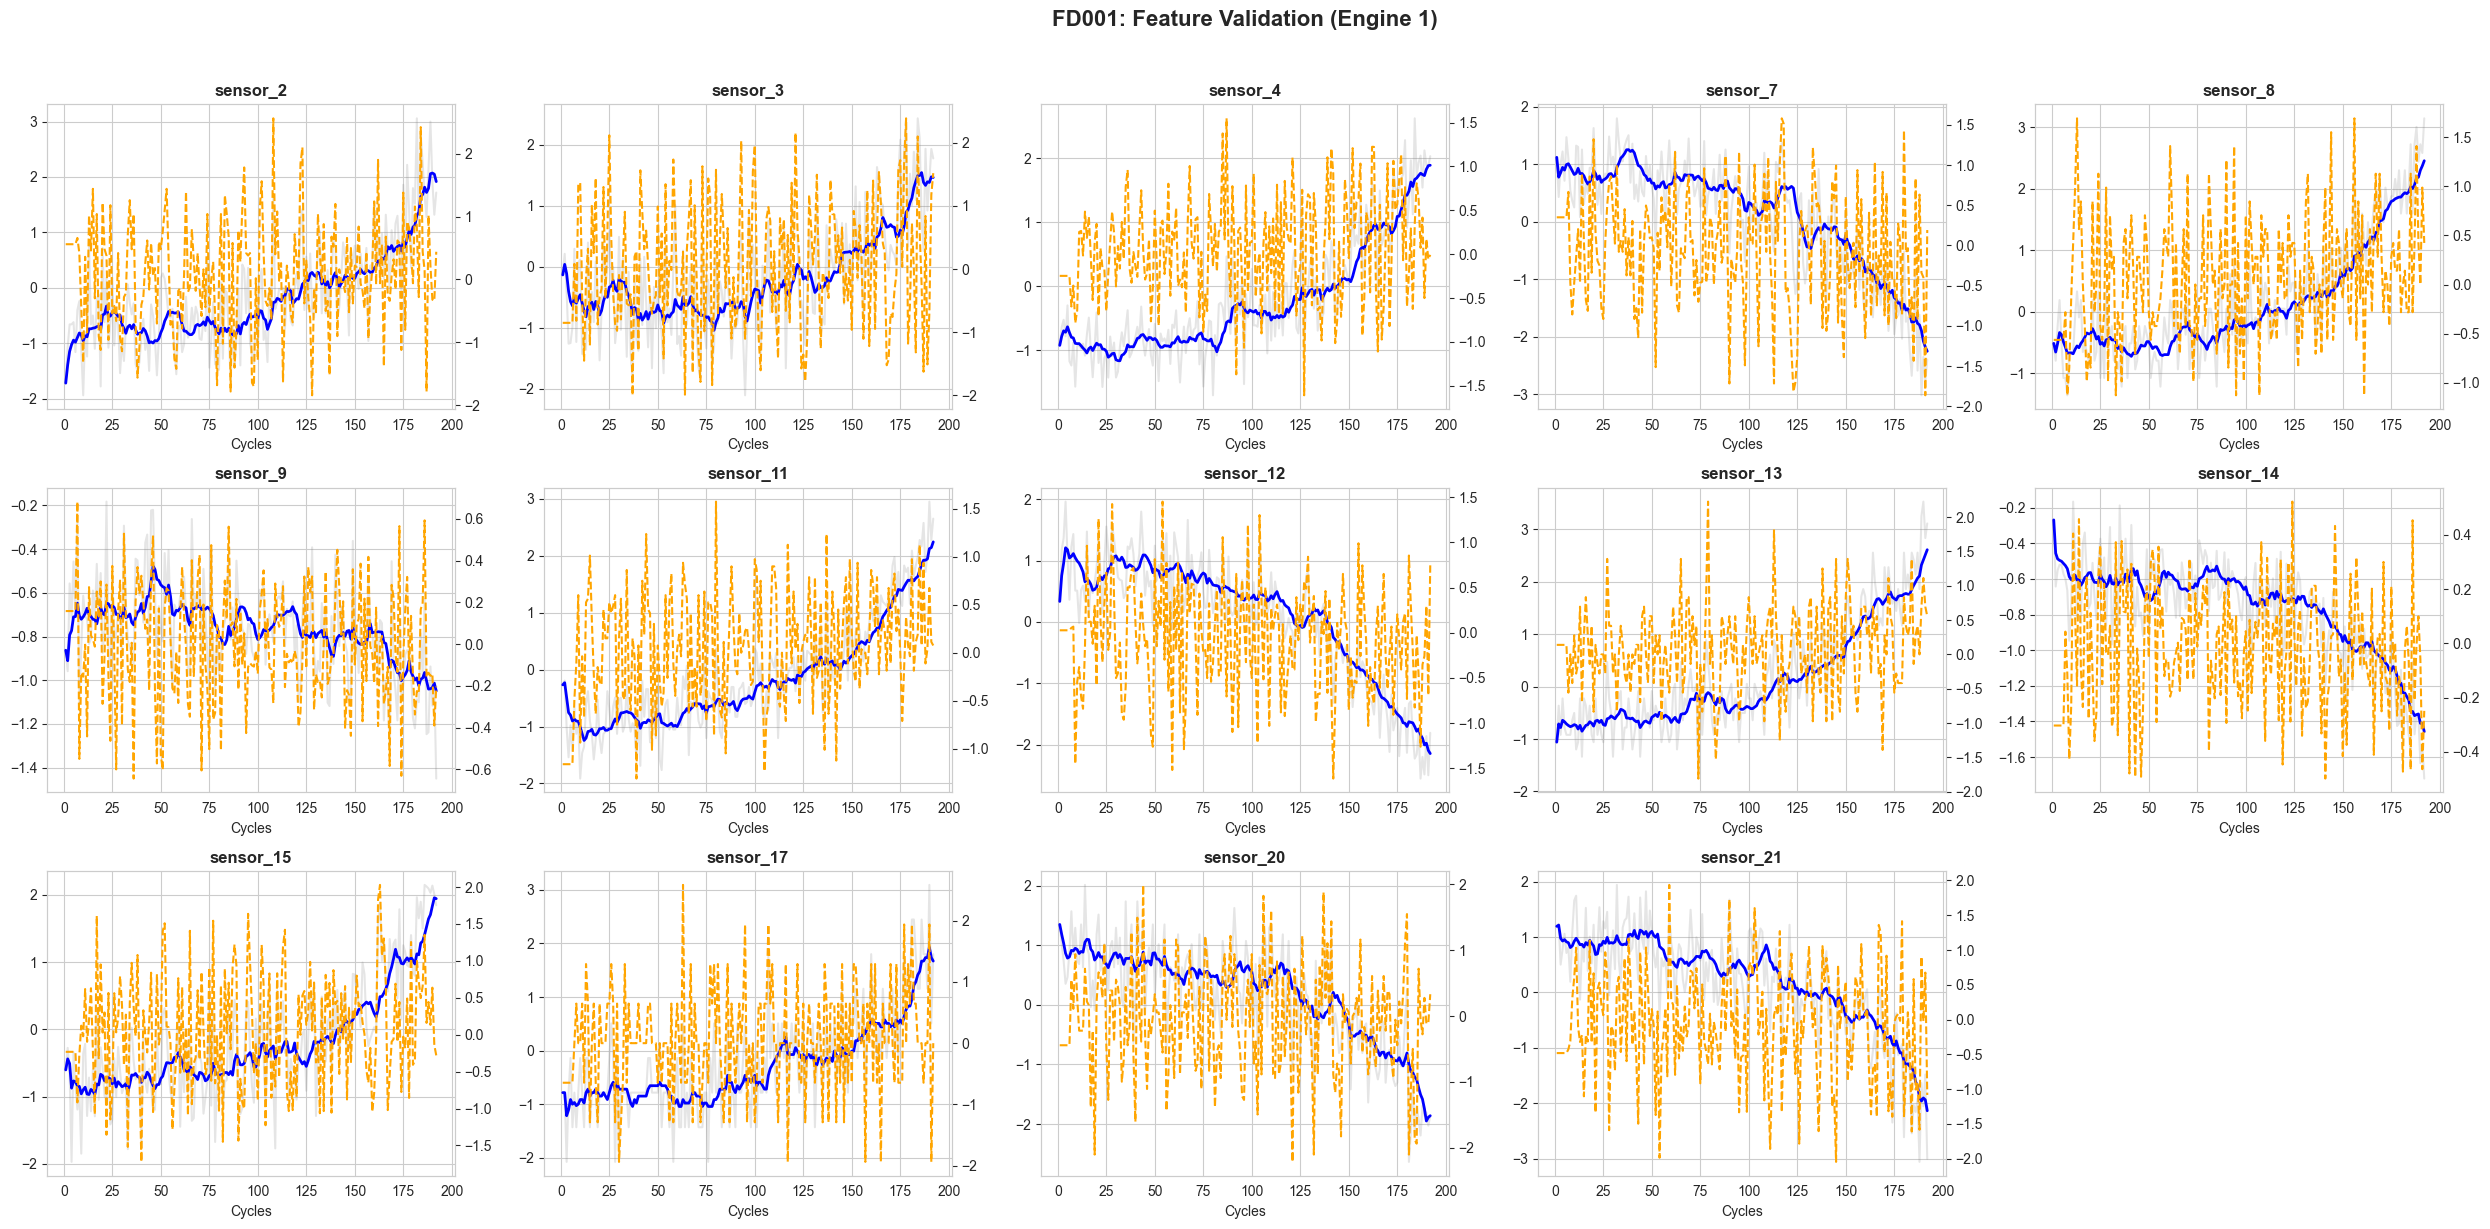

✅ Saved plot: feature_plots/final_feature_validation\FD002_feature_check.png


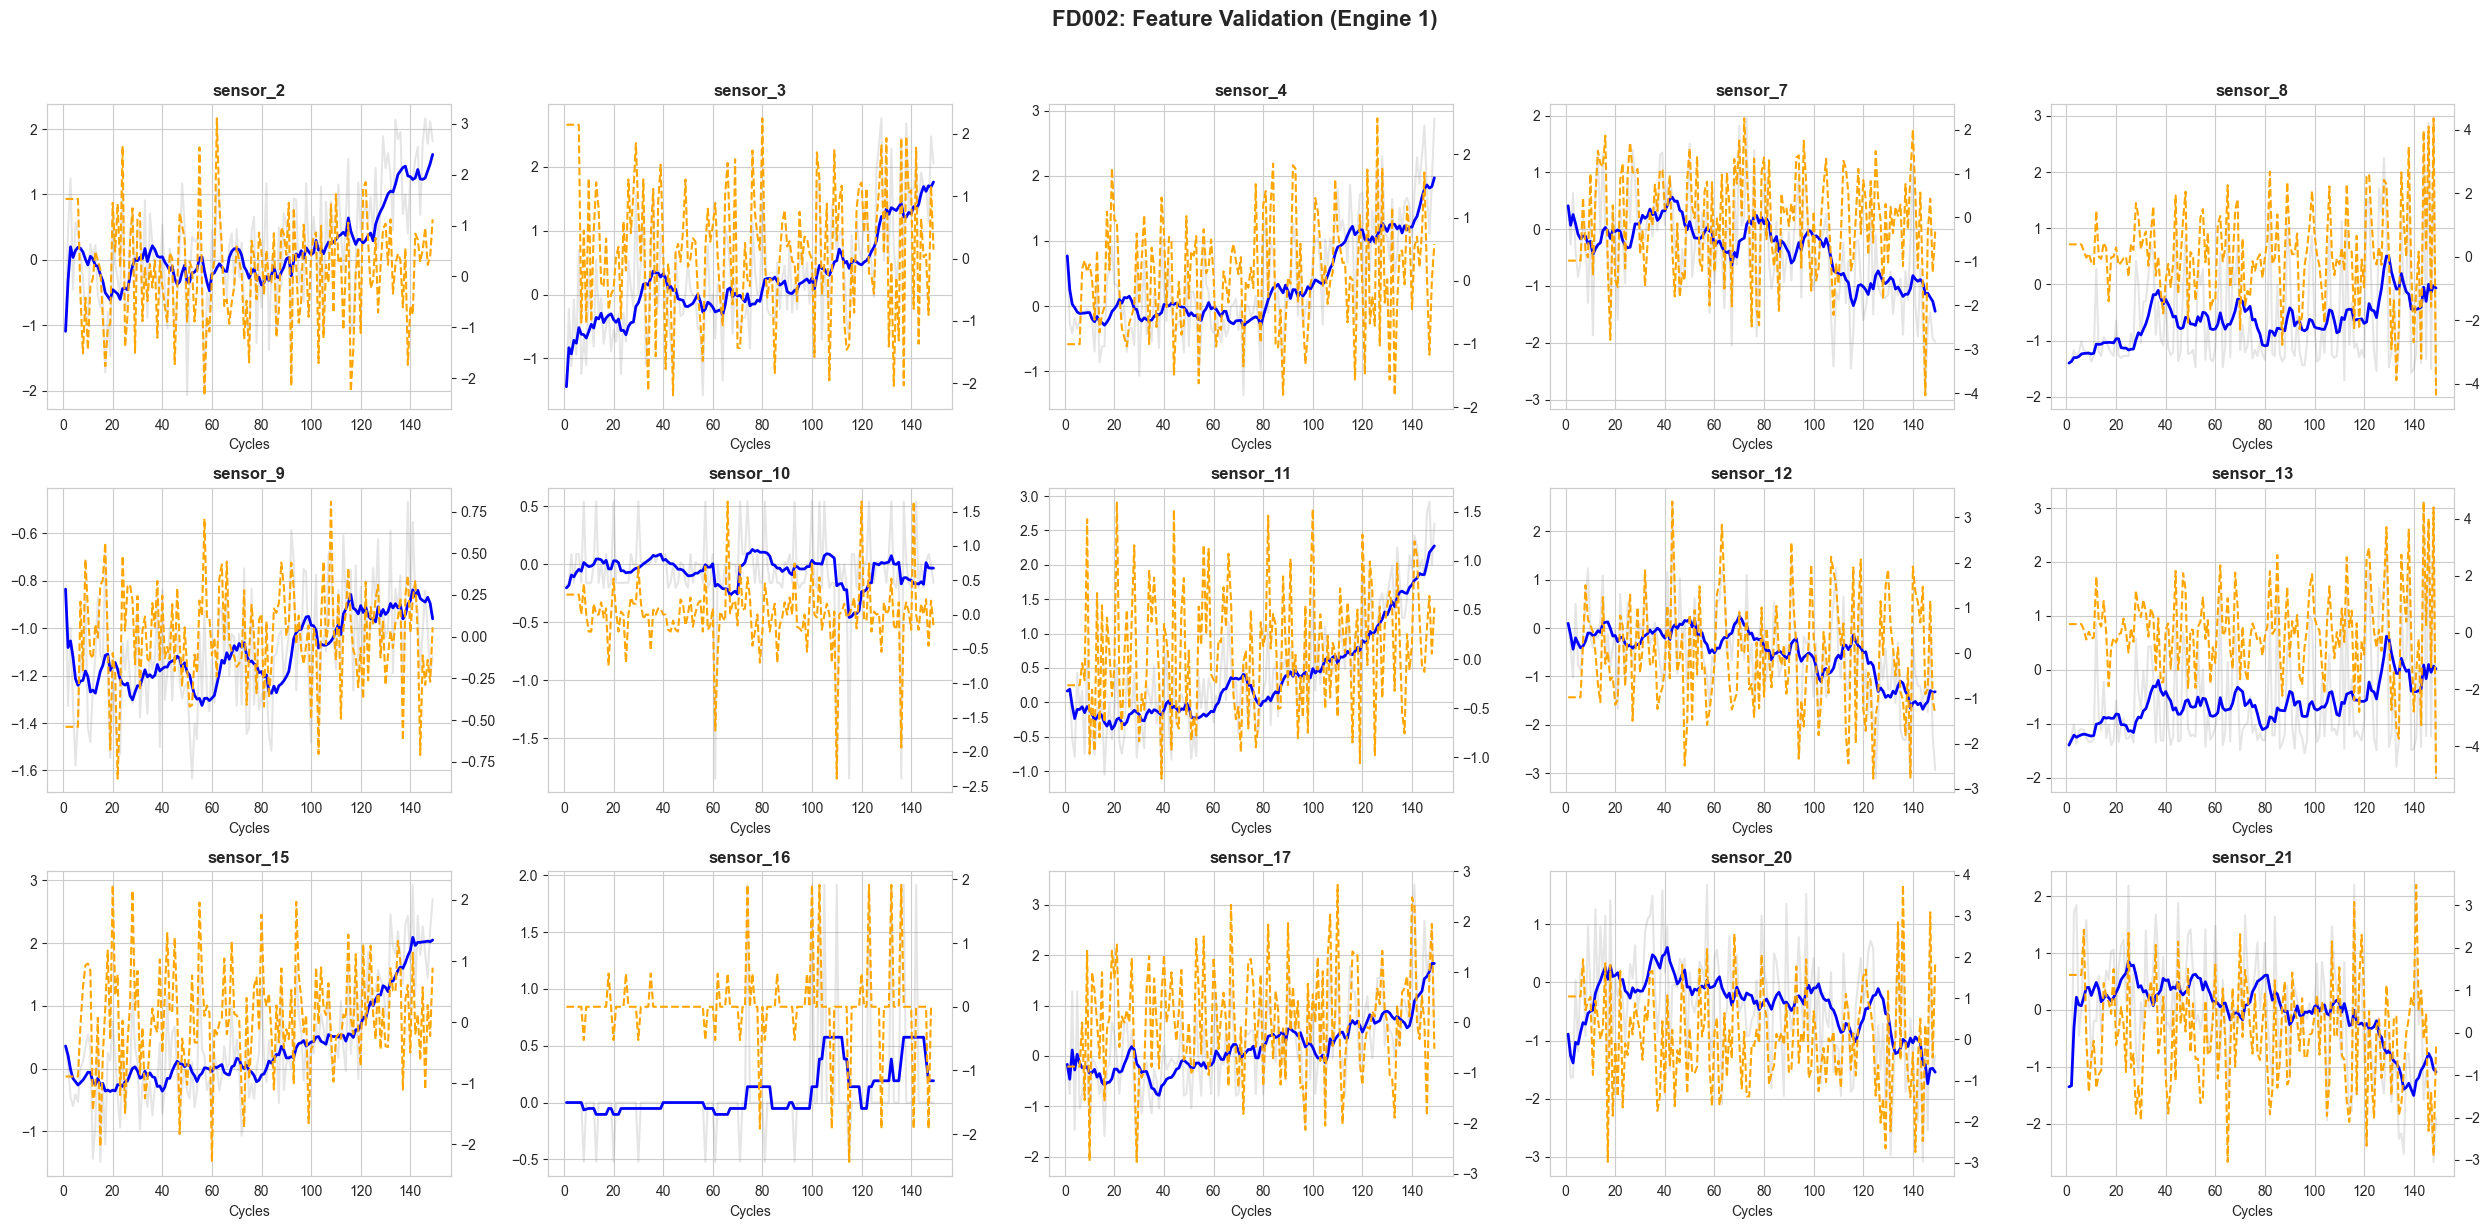

✅ Saved plot: feature_plots/final_feature_validation\FD003_feature_check.png


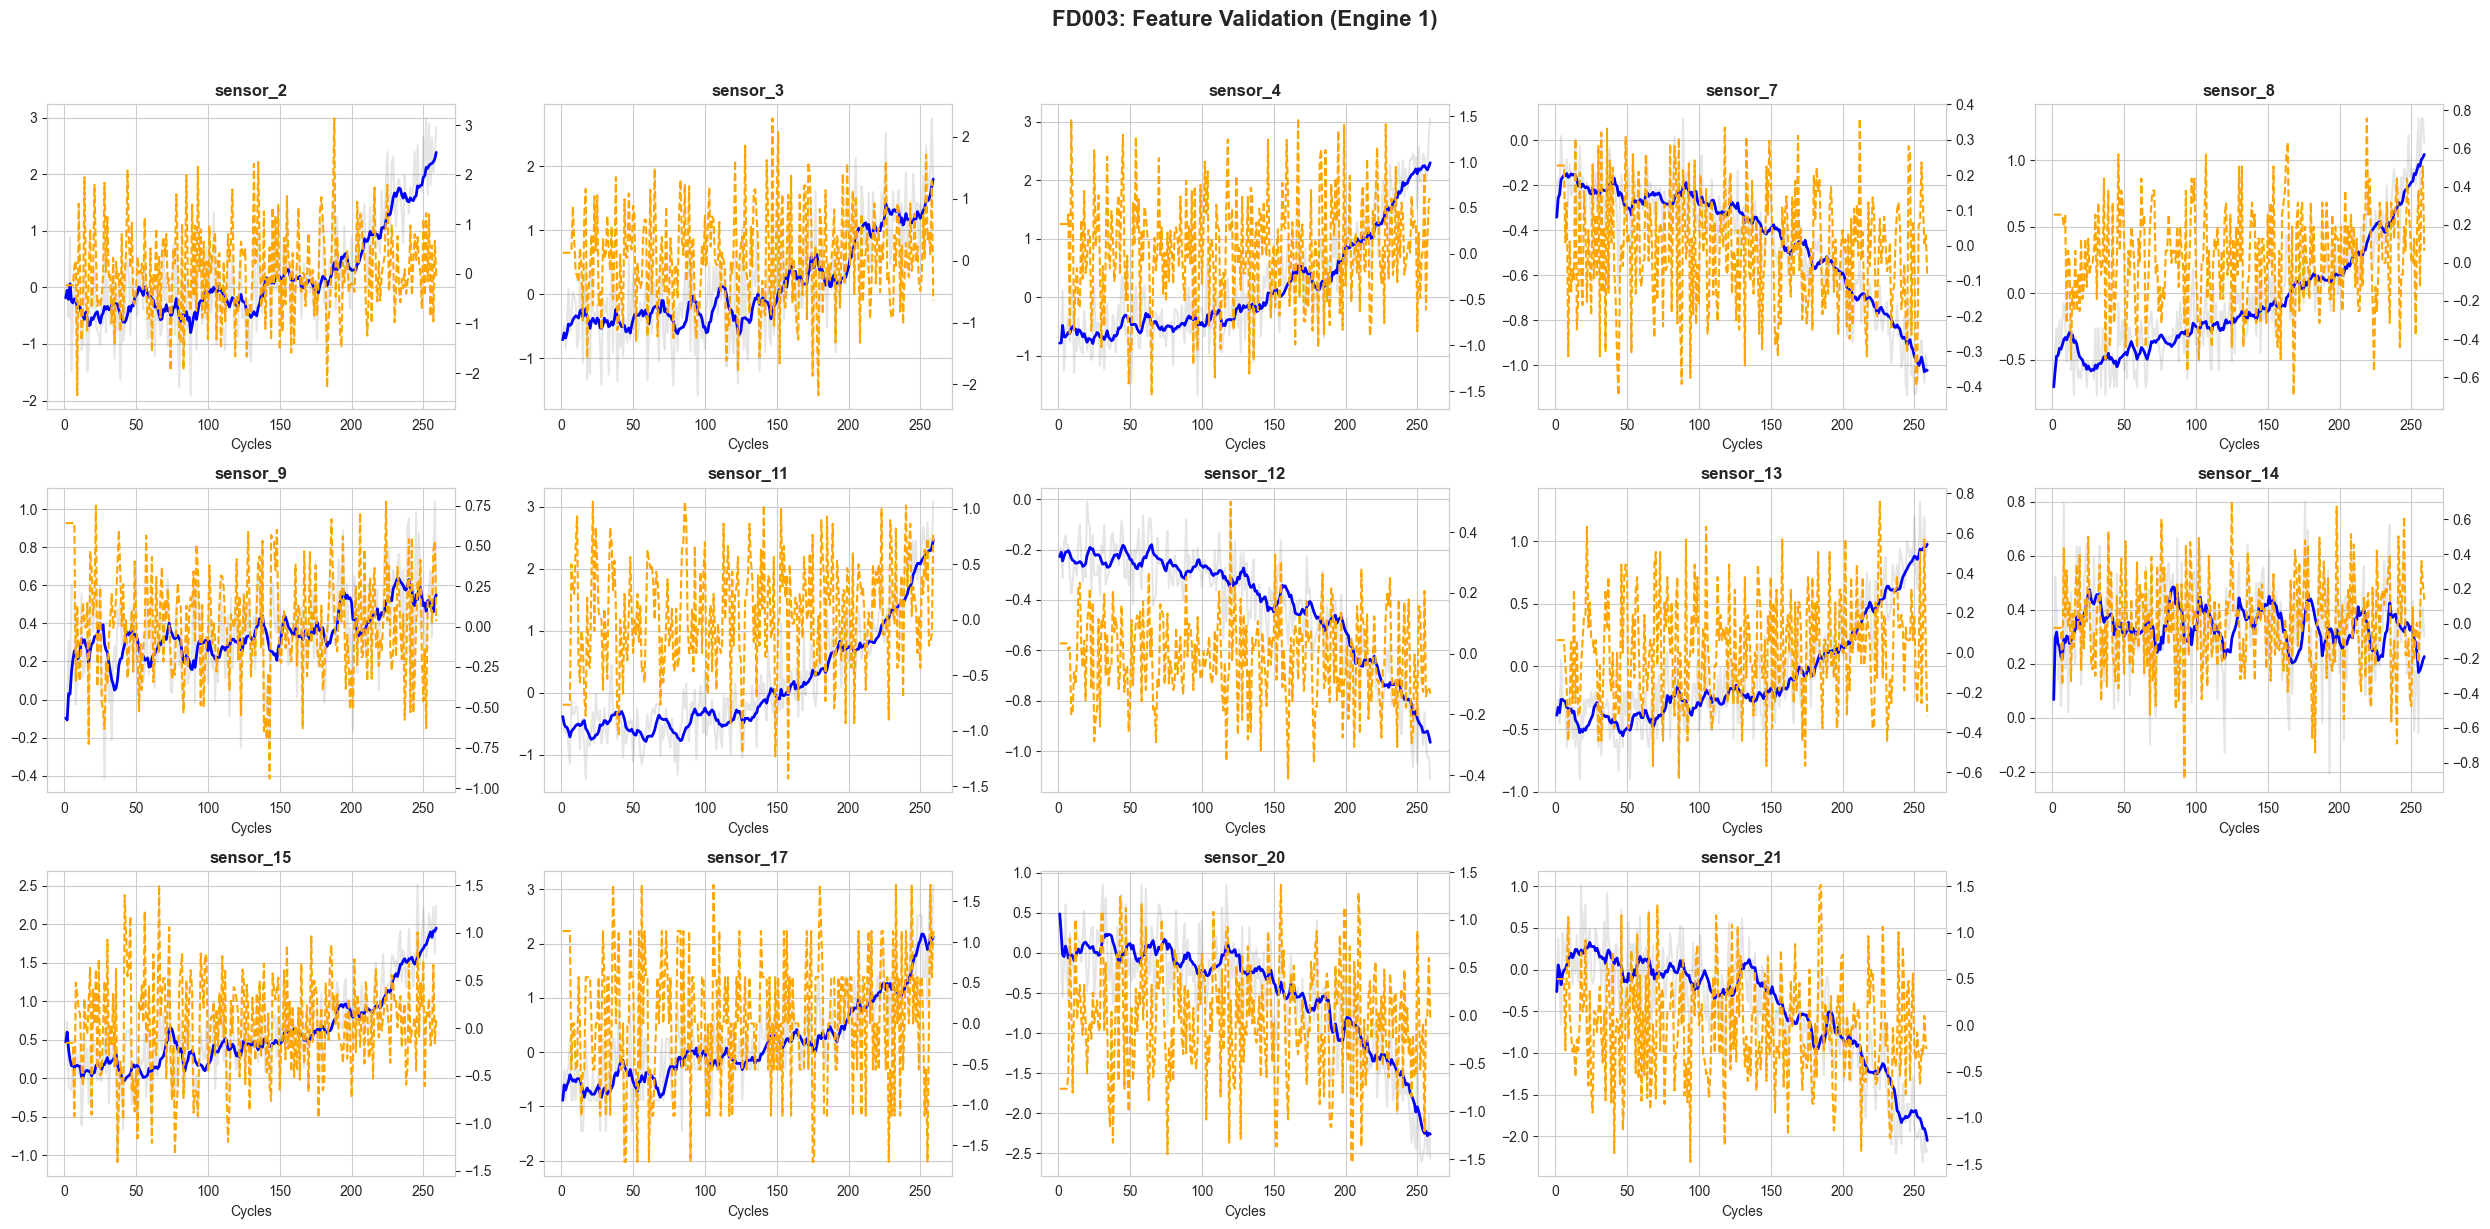

✅ Saved plot: feature_plots/final_feature_validation\FD004_feature_check.png


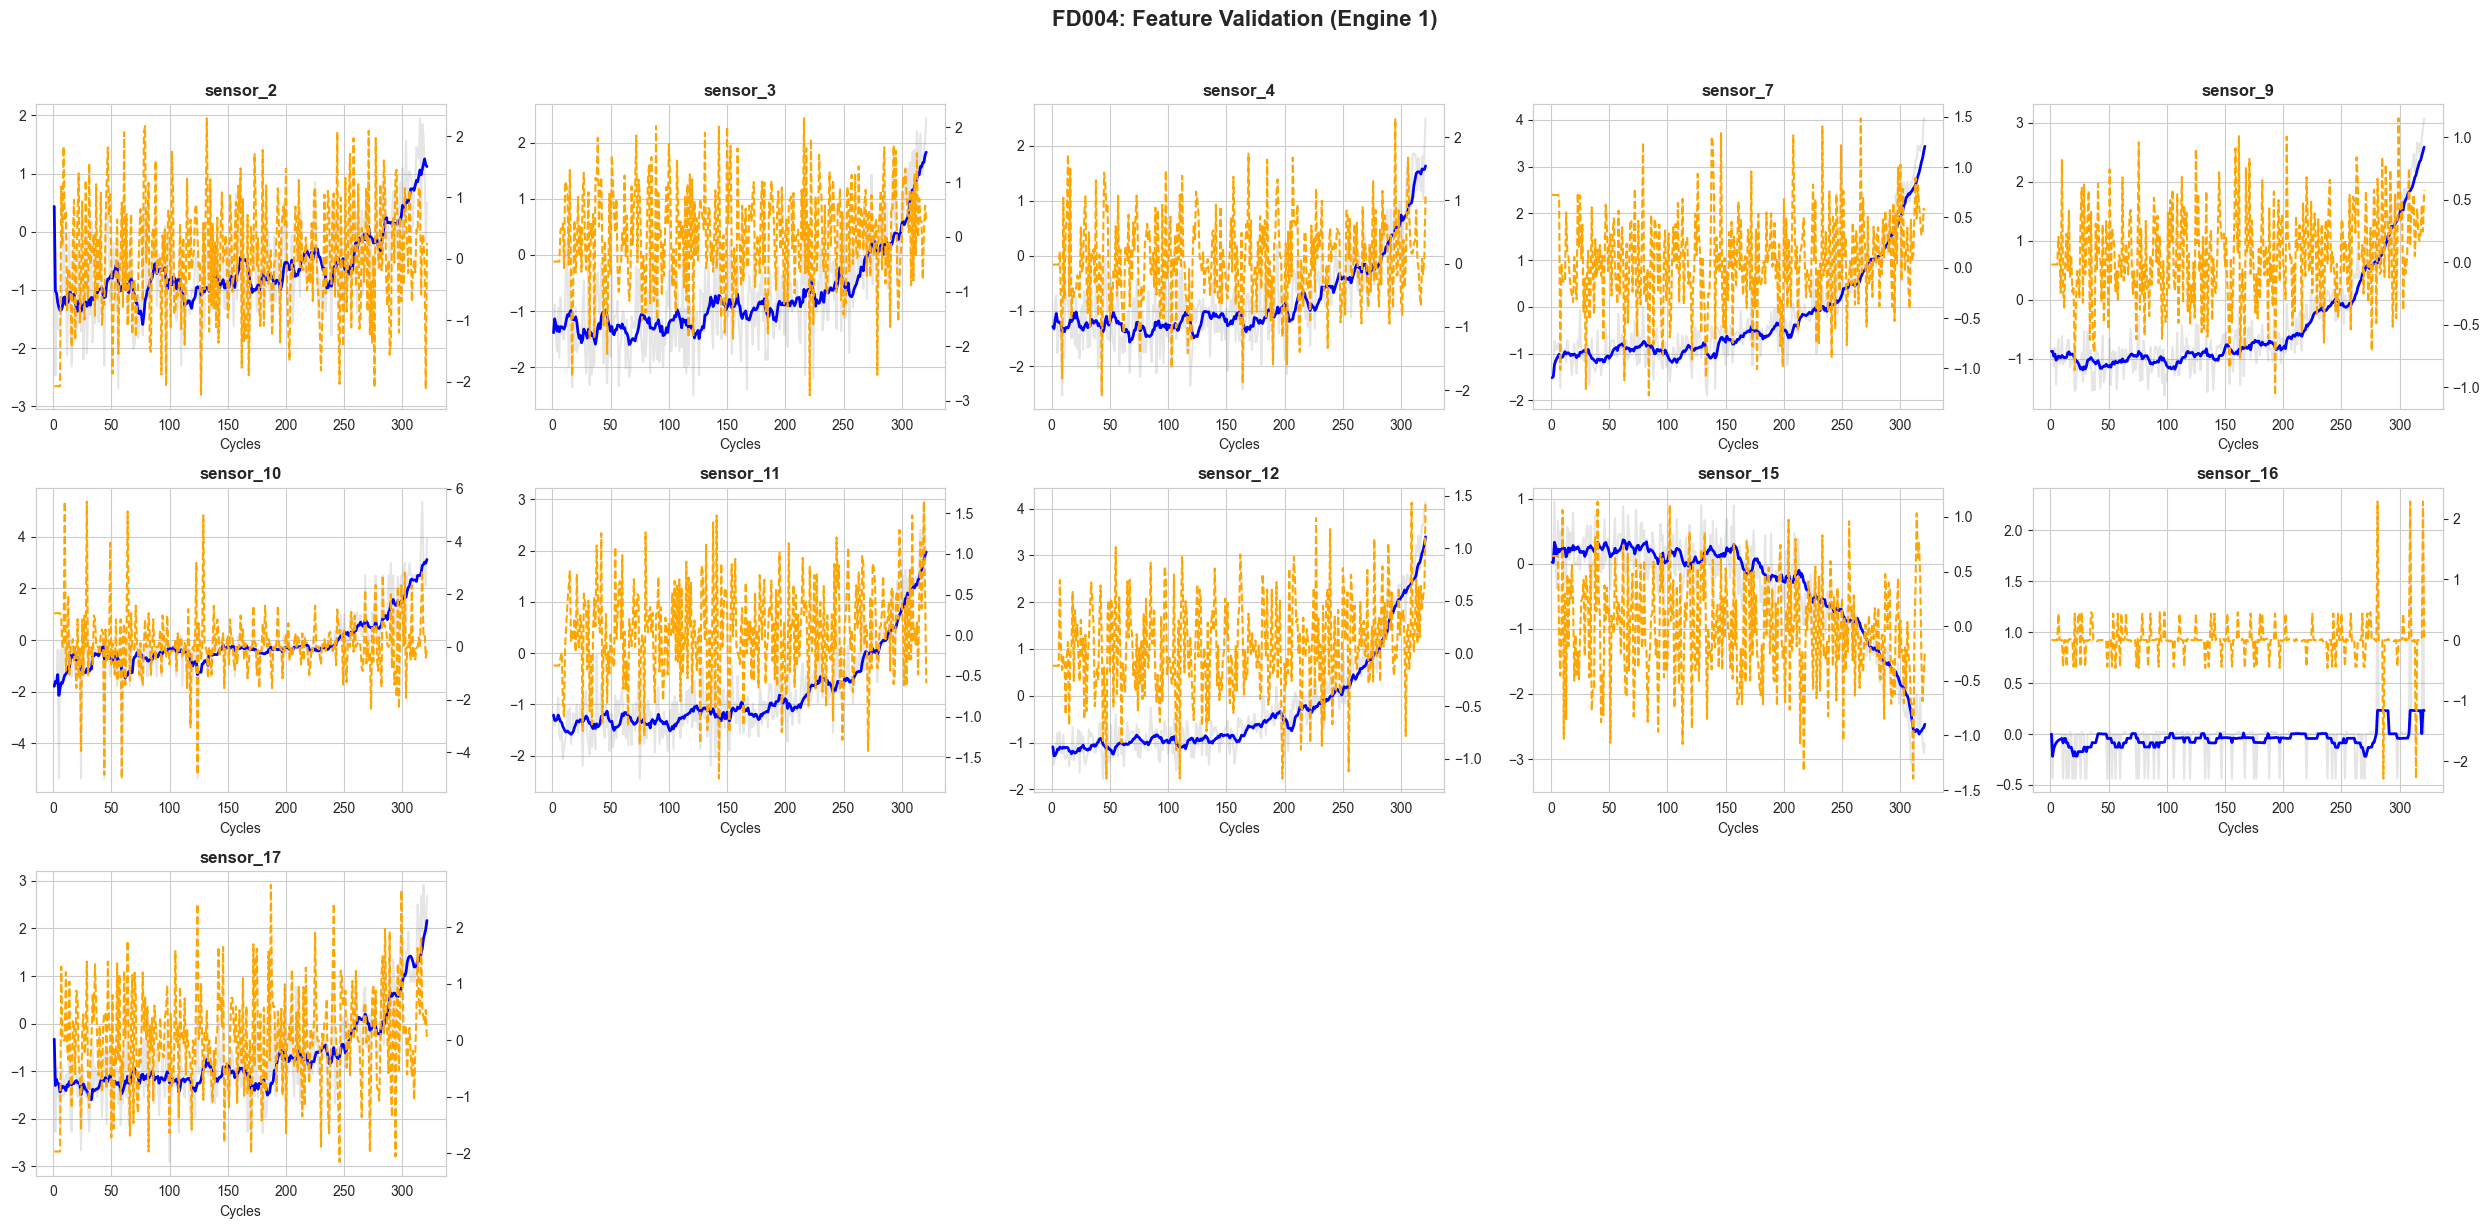

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def visualize_lag_features_fixed(dataset_list, input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    sns.set_style("whitegrid")
    
    for ds in dataset_list:
        path = os.path.join(input_dir, f"train_{ds}_engineered.csv")
        if not os.path.exists(path): continue
        
        df = pd.read_csv(path)
        # Fix: Identify the original sensors by looking for columns that don't have suffixes
        all_sensors = [c for c in df.columns if c.startswith('sensor_')]
        base_sensors = [c for c in all_sensors if not any(suffix in c for suffix in ['_mean', '_std', '_delta'])]
        
        num_sensors = len(base_sensors)
        if num_sensors == 0:
            print(f"⚠️ No base sensors found for {ds}. Check column names.")
            continue
            
        # Ensure 'time' exists
        if 'time' not in df.columns: df['time'] = df['cycle']
            
        unit_id = df['unit_id'].min()
        sample = df[df['unit_id'] == unit_id].sort_values('time')
        
        rows = (num_sensors + 4) // 5
        fig, axes = plt.subplots(rows, 5, figsize=(25, 4 * rows))
        axes = axes.flatten()
        
        for idx, sensor in enumerate(base_sensors):
            ax = axes[idx]
            
            # Plot Raw and Mean
            ax.plot(sample['time'], sample[sensor], alpha=0.2, label='Raw', color='gray')
            if f"{sensor}_mean" in df.columns:
                ax.plot(sample['time'], sample[f"{sensor}_mean"], label='Mean (W=10)', color='blue', lw=2)
            
            # Secondary axis for Delta
            if f"{sensor}_delta" in df.columns:
                ax_delta = ax.twinx()
                ax_delta.plot(sample['time'], sample[f"{sensor}_delta"], label='Delta (L=5)', color='orange', ls='--', lw=1.5)
                ax_delta.grid(False) # Hide overlapping grid
            
            ax.set_title(f"{sensor}", fontweight='bold')
            ax.set_xlabel("Cycles")
            
        for idx in range(num_sensors, len(axes)): fig.delaxes(axes[idx])
            
        plt.suptitle(f"{ds}: Feature Validation (Engine {unit_id})", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        save_path = os.path.join(output_dir, f"{ds}_feature_check.png")
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
        print(f"✅ Saved plot: {save_path}")
        plt.show()
        plt.close()

# Run the fixed visualizer
visualize_lag_features_fixed(
    dataset_list=['FD001', 'FD002', 'FD003', 'FD004'],
    input_dir="data/engineered_features",
    output_dir="feature_plots/final_feature_validation"
)

#### **Step 3: Target Engineering (RUL Clipping)**

We implement a **Piecewise Linear RUL** strategy to stabilize the training process.

* **Objective:** Prevent the model from "over-fitting" to noise in the healthy phase of the engine's life.
* **Threshold:** We clip the maximum RUL at **125 cycles**. This is the industry-standard "knee point" for C-MAPSS engines, representing the onset of detectable degradation.
* **Effect:** The model learns a binary concept ("Healthy" vs. "Degrading") combined with a regression task (predicting the exact slope of degradation).

In [18]:
import pandas as pd
import os

# --- Configuration ---
INPUT_DIR = "data/engineered_features"
OUTPUT_DIR = "data/final_processed"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RUL_CLIP_LIMIT = 125

def clip_rul_target(df, limit=125):
    """
    Clips the RUL column to a maximum value to create a Piecewise Linear target function.
    """
    if 'RUL' in df.columns:
        # Create a new column for the clipped target (preserving the original for reference if needed)
        df['RUL_clipped'] = df['RUL'].clip(upper=limit)
        print(f"   -> Clipped RUL at {limit} cycles.")
    else:
        print("   ⚠️ No 'RUL' column found. Skipping clipping (Likely Test set).")
    return df

# --- Processing Loop ---
datasets = ['FD001', 'FD002', 'FD003', 'FD004']

for ds in datasets:
    # We only apply RUL clipping to the TRAINING set, as that is what we optimize against.
    # The Test set usually doesn't have an RUL column (we predict it).
    
    # 1. Process Training Data
    train_file = f"train_{ds}_engineered.csv"
    train_path = os.path.join(INPUT_DIR, train_file)
    
    if os.path.exists(train_path):
        print(f"Processing {train_file}...")
        df_train = pd.read_csv(train_path)
        
        # Apply Clipping
        df_train = clip_rul_target(df_train, limit=RUL_CLIP_LIMIT)
        
        # Save Final Training Data
        save_path = os.path.join(OUTPUT_DIR, f"train_{ds}_final.csv")
        df_train.to_csv(save_path, index=False)
        print(f"   ✅ Saved Final Train: {save_path} ({df_train.shape})")

    # 2. Process Test Data (Just Copying/Passing through)
    # We don't clip 'RUL' in test because we don't train on it, but we move it to the final folder for consistency.
    test_file = f"test_{ds}_engineered.csv"
    test_path = os.path.join(INPUT_DIR, test_file)
    
    if os.path.exists(test_path):
        print(f"Processing {test_file}...")
        df_test = pd.read_csv(test_path)
        
        # Save Final Test Data
        save_path = os.path.join(OUTPUT_DIR, f"test_{ds}_final.csv")
        df_test.to_csv(save_path, index=False)
        print(f"   ✅ Saved Final Test:  {save_path} ({df_test.shape})\n")

Processing train_FD001_engineered.csv...
   -> Clipped RUL at 125 cycles.
   ✅ Saved Final Train: data/final_processed\train_FD001_final.csv ((20631, 65))
Processing test_FD001_engineered.csv...
   ✅ Saved Final Test:  data/final_processed\test_FD001_final.csv ((13096, 62))

Processing train_FD002_engineered.csv...
   -> Clipped RUL at 125 cycles.
   ✅ Saved Final Train: data/final_processed\train_FD002_final.csv ((53759, 69))
Processing test_FD002_engineered.csv...
   ✅ Saved Final Test:  data/final_processed\test_FD002_final.csv ((33991, 66))

Processing train_FD003_engineered.csv...
   -> Clipped RUL at 125 cycles.
   ✅ Saved Final Train: data/final_processed\train_FD003_final.csv ((24720, 65))
Processing test_FD003_engineered.csv...
   ✅ Saved Final Test:  data/final_processed\test_FD003_final.csv ((16596, 62))

Processing train_FD004_engineered.csv...
   -> Clipped RUL at 125 cycles.
   ✅ Saved Final Train: data/final_processed\train_FD004_final.csv ((61249, 53))
Processing test_F

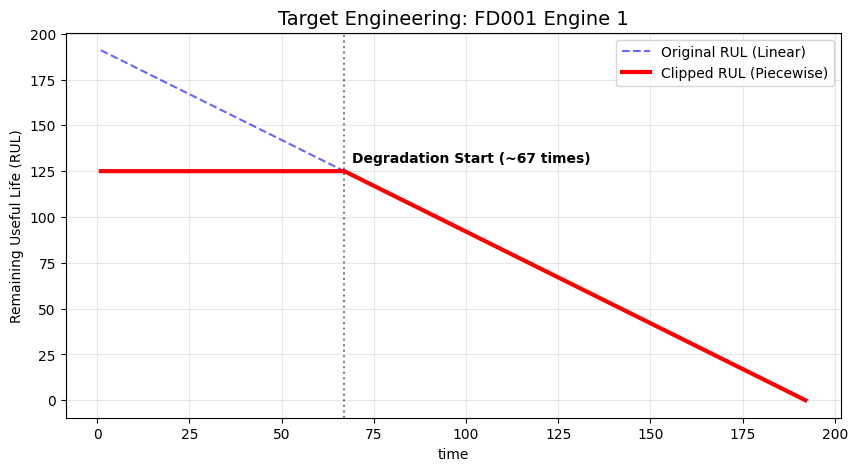

✅ Comparison plot saved to: feature_plots/target_engineering\FD001_target_comparison.png


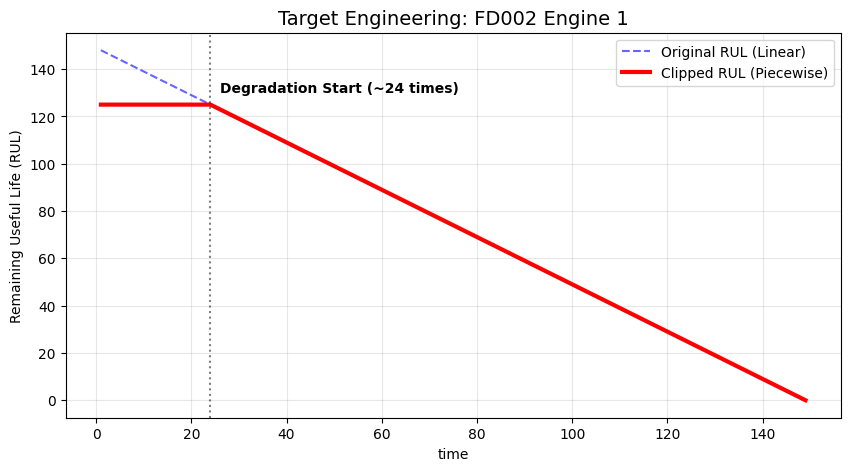

✅ Comparison plot saved to: feature_plots/target_engineering\FD002_target_comparison.png


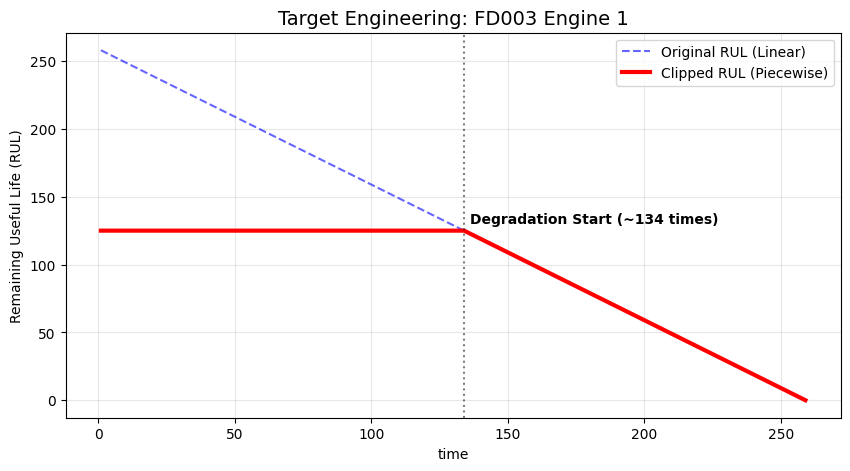

✅ Comparison plot saved to: feature_plots/target_engineering\FD003_target_comparison.png


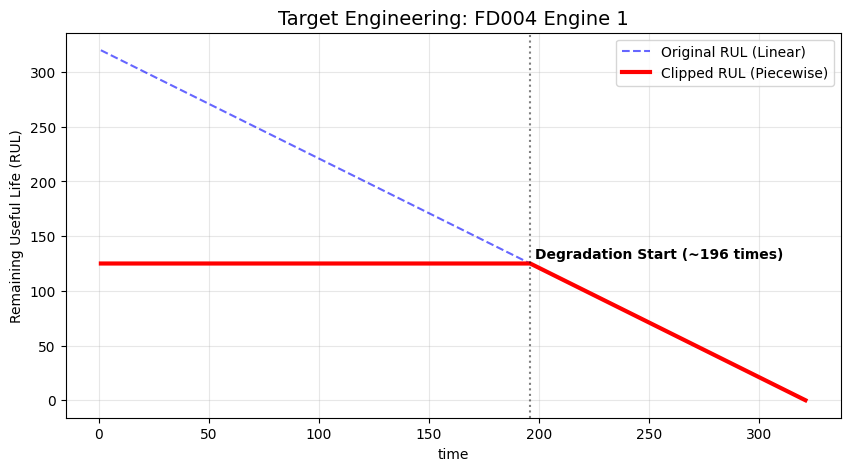

✅ Comparison plot saved to: feature_plots/target_engineering\FD004_target_comparison.png


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create directory for target plots
PLOTS_DIR = "feature_plots/target_engineering"
os.makedirs(PLOTS_DIR, exist_ok=True)

def visualize_rul_clipping(dataset='FD001'):
    # Load the finalized data
    file_path = f"data/final_processed/train_{dataset}_final.csv"
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return
        
    df = pd.read_csv(file_path)
    
    # Pick a sample engine (Unit 1)
    sample_id = df['unit_id'].min()
    sample_engine = df[df['unit_id'] == sample_id].sort_values('time')
    
    # Plotting
    plt.figure(figsize=(10, 5))
    
    # 1. Original Linear RUL
    plt.plot(sample_engine['time'], sample_engine['RUL'], 
             label='Original RUL (Linear)', color='blue', linestyle='--', alpha=0.6)
    
    # 2. Clipped RUL (The Piecewise Target)
    plt.plot(sample_engine['time'], sample_engine['RUL_clipped'], 
             label='Clipped RUL (Piecewise)', color='red', linewidth=3)
    
    # Add the "Knee Point" marker
    knee_time = sample_engine[sample_engine['RUL'] <= 125]['time'].min()
    plt.axvline(x=knee_time, color='black', linestyle=':', alpha=0.5)
    plt.text(knee_time+2, 130, f'Degradation Start (~{knee_time} times)', fontweight='bold')

    plt.title(f"Target Engineering: {dataset} Engine {sample_id}", fontsize=14)
    plt.xlabel("time")
    plt.ylabel("Remaining Useful Life (RUL)")
    plt.legend()
    plt.grid(alpha=0.3)
    
    save_path = os.path.join(PLOTS_DIR, f"{dataset}_target_comparison.png")
    plt.savefig(save_path, dpi=120)
    plt.show()
    print(f"✅ Comparison plot saved to: {save_path}")

# Run for FD001 as a representative sample
visualize_rul_clipping('FD001')
visualize_rul_clipping('FD002')
visualize_rul_clipping('FD003')
visualize_rul_clipping('FD004')